# Version 2 of the Model - Architecture Long Short-Term Memory (LSTM)

## Imports

In [4]:
from keras.callbacks import EarlyStopping, LearningRateScheduler, CallbackList, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
from keras.metrics import Precision, Recall, AUC
from tensorflow.keras.models import load_model
from sklearn.preprocessing import LabelEncoder
from tokenizers import BertWordPieceTokenizer
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Sequential
from keras.utils import to_categorical
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from tensorflow import keras
import tensorflow as tf
from tqdm import tqdm
import pandas as pd
import transformers
import numpy as np
import warnings
import spacy
import math
import nltk

In [5]:
warnings.filterwarnings('ignore')
%env TF_CPP_MIN_LOG_LEVEL=3

env: TF_CPP_MIN_LOG_LEVEL=3


## Loading the Datasets

In [6]:
# Loading training data
training_data = pd.read_csv('dados_treino.txt', header=None, delimiter=';')

# Loading test data
training_test = pd.read_csv('dados_teste.txt', header=None, delimiter=';')

# Adjusting column names
training_data = training_data.rename(columns={0:'text', 1:'feeling'})
training_test = training_test.rename(columns={0:'text', 1:'feeling'})

In [7]:
# Looking at the shape of the data
print('Training: ', training_data.shape)
print('Test: ', training_test.shape)

Training:  (16000, 2)
Test:  (2000, 2)


In [8]:
# Feelings present in training data
print('Data of training ', training_data['feeling'].value_counts())
# feelings presentes nos dados de teste
print('Data of test', training_test['feeling'].value_counts())


Data of training  feeling
joy         5362
sadness     4666
anger       2159
fear        1937
love        1304
surprise     572
Name: count, dtype: int64
Data of test feeling
joy         695
sadness     581
anger       275
fear        224
love        159
surprise     66
Name: count, dtype: int64


## Text data pre-processing

In [9]:
# Downloading the dictionary to simplify the text
!python -m spacy download en_core_web_md -q

# Loading the dictionary
dict_nlp = spacy.load('en_core_web_md')

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')


In [10]:
# Creating a function that will receive text as a parameter to be "simplified"
def simplifies_text(text):
    
    # Process the text using the dictionary
    doc = dict_nlp(text)

    # Creates a list of lemmas from the tokens, converted to lowercase and without whitespace,
    # And excluding words that are stopwords
    tokens = [token.lemma_.lower().strip() for token in doc if not token.is_stop]

    # Returns the processed tokens as a single string, joining them with spaces
    return ' '.join(tokens)

In [11]:
# Applying the function to training data
training_data['processed_text'] = training_data['text'].apply(simplifies_text)

# Applying the function to test data
training_test['processed_text'] = training_test['text'].apply(simplifies_text)

# Viewing the data
training_data.head()

,text,feeling,processed_text
0,i am feeling completely overwhelmed i have two...,fear,feel completely overwhelmed strategy help feel...
1,i have the feeling she was amused and delighted,joy,feeling amuse delight
2,i was able to help chai lifeline with your sup...,joy,able help chai lifeline support encouragement ...
3,i already feel like i fucked up though because...,anger,feel like fuck not usually eat morning
4,i still love my so and wish the best for him i...,sadness,love wish good long tolerate effect bm life fa...


## Tokenizer

In [12]:
# Creation of the tokenizer
# This function comes from the Keras module (from keras.preprocessing.text import Tokenizer)
cod_tokenizador = Tokenizer()

# Adjusting the tokenizer with the processed texts
# (The tokenizer will apply a type of encoding to each word in the sentence)
cod_tokenizador.fit_on_texts(training_data['processed_text'])

# Extract the index of each word (This index is the encoding applied by the tokenizer)
word_index = cod_tokenizador.word_index

In [13]:
print('size of these "index":', len(word_index))

size of these "index": 11896


In [15]:
# Setting the maximum length of sequences
max_length = 100

# Conversion of training texts to token sequences generated by the tokenizer
training_sequences = cod_tokenizador.texts_to_sequences(training_data['processed_text'])

# Padding of training sequences
training_sequences_padded = pad_sequences(training_sequences, maxlen=max_length, truncating='post')

# Conversion of test text to token sequence
test_sequences = cod_tokenizador.texts_to_sequences(training_test['processed_text'])

# Padding test sequences
test_sequences_padded = pad_sequences(test_sequences, maxlen=max_length)

In [16]:
# Creation of the label encoder
enc_le = LabelEncoder()

# Fit and Transform the sentiment labels to the training data
y_training_le = enc_le.fit_transform(training_data['feeling'])

# Transformation of feeling labels for test data
y_test_le = enc_le.transform(training_test['feeling'])

# Converting labels to categorical variables
y_training_encoded = to_categorical(y_training_le)
y_test_encoded = to_categorical(y_test_le)

In [17]:
# Setting vocabulary size
vocab_size = len(cod_tokenizador.word_index) + 1

# Defining the embedding dimension
embedding_dim = max_length

In [18]:
# Construction of the LSTM model
model_LSTM = tf.keras.Sequential([Embedding(vocab_size, embedding_dim, input_length=max_length), 
                                      Bidirectional(LSTM(128)),
                                      Dropout(0.5),
                                      Dense(64, activation='leaky_relu', kernel_regularizer='l1_l2'),
                                      Dropout(0.5),
                                      Dense(6, activation='softmax')])

In [19]:
# Model compilation
model_LSTM.compile(loss='categorical_crossentropy',
                      optimizer='adam',
                      metrics=['accuracy', Precision(), Recall(), AUC()])

# Displaying the model summary
print(model_LSTM.summary())


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 100)          1189700   
                                                                 
 bidirectional (Bidirection  (None, 256)               234496    
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense (Dense)               (None, 64)                16448     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 6)                 390       
                                                       

In [20]:
# Transforming input data into array format
input_data = np.array(training_sequences_padded)

#Transforming the output data to array format
output_data = np.array(y_training_encoded)

# Definition of hyperparameters
num_epochs = 35
validation_split_value = 0.2
paciencia = 4

# Early Stopping Configuration
early_stopping = tf.keras.callbacks.EarlyStopping(patience=paciencia)

In [21]:
# Training the model
history = model_LSTM.fit(input_data, 
                            output_data,
                            epochs=num_epochs,
                            verbose=1,
                            validation_split= validation_split_value,
                            callbacks=[early_stopping])

Epoch 1/35


400/400 [==============================] - 17s 38ms/step - loss: 3.1799 - accuracy: 0.3249 - precision: 0.2778 - recall: 7.8125e-04 - auc: 0.7018 - val_loss: 1.6677 - val_accuracy: 0.3262 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.7135
Epoch 2/35
400/400 [==============================] - 14s 35ms/step - loss: 1.6118 - accuracy: 0.3271 - precision: 0.5615 - recall: 0.0189 - auc: 0.7371 - val_loss: 1.4291 - val_accuracy: 0.3291 - val_precision: 0.5257 - val_recall: 0.2272 - val_auc: 0.8082
Epoch 3/35
400/400 [==============================] - 14s 35ms/step - loss: 1.3287 - accuracy: 0.4248 - precision: 0.5312 - recall: 0.1616 - auc: 0.8501 - val_loss: 1.2797 - val_accuracy: 0.4425 - val_precision: 0.5185 - val_recall: 0.2628 - val_auc: 0.8593
Epoch 4/35
400/400 [==============================] - 14s 34ms/step - loss: 1.2141 - accuracy: 0.4487 - precision: 0.5303 - recall: 0.2189 - auc: 0.8704 - val_loss: 1.2418 - val_accuracy: 0.4350 - val_precision: 

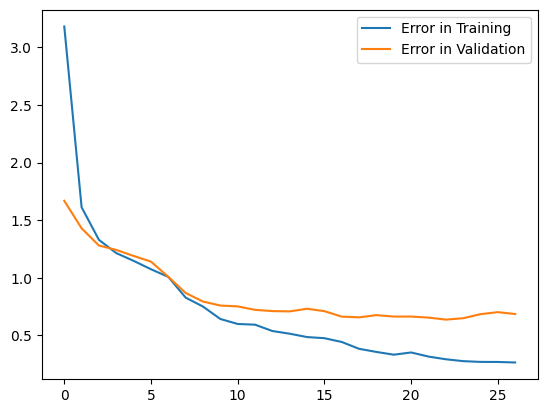

In [22]:
# Plot of error curves
loss, val_loss, = history.history['loss'], history.history['val_loss']
plt.plot(loss, label='Error in Training')
plt.plot(val_loss, label='Error in Validation')
plt.legend()
plt.show()

In [23]:
# Predictions with test data
prevision = model_LSTM.predict(test_sequences_padded)

# Determination of predicted labels
prevision_labels = prevision.argmax(axis=1)

# Ranking report display
print(classification_report(y_test_le, prevision_labels))

63/63 [==============================] - 1s 12ms/step
              precision    recall  f1-score   support

           0       0.89      0.87      0.88       275
           1       0.85      0.83      0.84       224
           2       0.93      0.90      0.91       695
           3       0.72      0.77      0.74       159
           4       0.91      0.93      0.92       581
           5       0.70      0.70      0.70        66

    accuracy                           0.88      2000
   macro avg       0.83      0.84      0.83      2000
weighted avg       0.88      0.88      0.88      2000



In [195]:
# Confusion Matrix Display
print(confusion_matrix(y_test_le, prevision_labels))

[[246   6   5   1  17   0]
 [ 10 201   2   1   6   4]
 [  2   2 648  26  13   4]
 [  3   1  32 113  10   0]
 [ 12   6  16   2 545   0]
 [  0  14   6   0   1  45]]


In [196]:
# Display of model accuracy
print(accuracy_score(y_test_le, prevision_labels))

0.899


In [24]:
# Saving the Model
model_LSTM.save('model_LSTM.keras')

In [30]:
# Model Deploy

# Load the saved model
loaded_model = load_model('model_LSTM.keras')

# New phrase (feeling = (love))
phrase = "Pure love is the gentle breeze that caresses without demand, the unconditional embrace of the soul"

# Create a pandas df with the phrase
df_phrase = pd.DataFrame({'phrase':[phrase]})

# Apply the processing function to the phrase (cleans the phrase)
df_phrase['processed_sentence'] = df_phrase['phrase'].apply(simplifies_text)

# Transform the phrase into tokens with tokinazer
sequencias_phrase = cod_tokenizador.texts_to_sequences(df_phrase['processed_sentence'])
sequencias_phrase_padded = pad_sequences(sequencias_phrase, maxlen=max_length)

# Make predictions with the loaded model
prevision = loaded_model.predict(sequencias_phrase_padded)

# Select the class with the highest probability
class_largest_prob = np.argmax(prevision, axis=1)

# Get the name of the class by doing the inverse transformation
class_name = enc_le.inverse_transform(class_largest_prob)

print('Predicted class:', class_name)

1/1 [==============================] - 0s 405ms/step
Predicted class: ['love']
